In [1]:
import pandas as pd
import statistics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

Infant mortality rate (per 1000 live births     -0.702155
Fertility rate, total (live births per woman)   -0.635398
Employment: Agriculture (% of employed)         -0.579133
Food production index (2004-2006=100)           -0.087777
Agricultural production index (2004-2006=100)   -0.079540
Name: Happiness, dtype: float64
Economy: Services and other activity (% of GVA)          0.580328
Urban population (% of total population)                 0.666212
Employment: Services (% of employed)                     0.709983
GDP per capita (current US$)                             0.729044
Mobile-cellular subscriptions (per 100 inhabitants).1    0.789833
Name: Happiness, dtype: float64


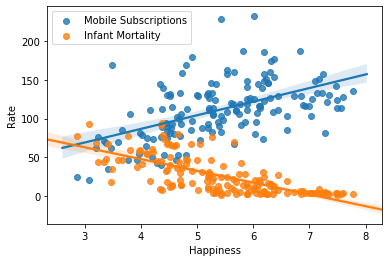

In [30]:
happiness = pd.read_csv('2019d.csv')
stats_toomany = pd.read_csv('country_statsd.csv')

keep_countries = [] #list of common countries
for i in stats_toomany.country:
    for j in happiness['Country or region']: #search thru the happiness file
        if i==j:                             #and see if the country names match
            keep = keep_countries.append(i)  #if they do, add them to the common list

#creating new dataframe with all columns of stats_toomany, 
#but only for countries that are also in the happiness dataset

stats = stats_toomany[(stats_toomany['country'].isin(keep_countries))]

# checking that datasets match
stats.sort_values(by=['country'])
happiness.sort_values(by=['Country or region'])
stats.shape
happiness.shape
stats.head(5)

#Using the clean data to find correlations
#on a scale of -1 to 1

# adding the happiness scores to the stats dataset to check correlations
stats.sort_values(by=['country'])
happiness.sort_values(by=['Country or region'])
stats['Happiness']=happiness['Score']

stats.replace(to_replace='...', value =0, inplace=True) #changing strings to integers
stats.replace(to_replace='~0.0', value =0, inplace=True)
stats.replace(to_replace='-~0.0', value =0, inplace=True)

correlations = stats.corr()
correlations.sort_values(by=['Happiness'], inplace=True)
correlations
bottom5cor = correlations[:5]['Happiness']
print(bottom5cor)
top5cor = correlations[-6:-1]['Happiness']
print(top5cor)

#since mobile cell subscriptions seems to have the biggest positive
#effect on happiness let's plot it

a=sns.regplot(x=stats['Happiness'], y=stats['Mobile-cellular subscriptions (per 100 inhabitants)'],label="Mobile Subscriptions");

#since Infant mortality rate seems to have the 
#biggest negative effect on happiness let's plot it
a=sns.regplot(x=stats['Happiness'], y=stats['Infant mortality rate (per 1000 live births'], label="Infant Mortality");
a.set(ylabel="Rate")
a.legend()

In [42]:
print(correlations.columns)

Index(['Surface area (km2)', 'Population in thousands (2017)',
       'Population density (per km2, 2017)', 'Sex ratio (m per 100 f, 2017)',
       'GDP: Gross domestic product (million current US$)',
       'GDP growth rate (annual %, const. 2005 prices)',
       'GDP per capita (current US$)', 'Economy: Industry (% of GVA)',
       'Economy: Services and other activity (% of GVA)',
       'Employment: Agriculture (% of employed)',
       'Employment: Industry (% of employed)',
       'Employment: Services (% of employed)',
       'Agricultural production index (2004-2006=100)',
       'Food production index (2004-2006=100)',
       'International trade: Exports (million US$)',
       'International trade: Imports (million US$)',
       'International trade: Balance (million US$)',
       'Urban population (% of total population)',
       'Fertility rate, total (live births per woman)',
       'Infant mortality rate (per 1000 live births',
       'Health: Total expenditure (% of GDP)'

In [58]:
print(correlations['Infant mortality rate (per 1000 live births'])
# surface ared km2 and co2 emission est have .775
#'Population in thousands (2017)' and co2 emission est have .690
# GDP: Gross domestic product (million current US$) and co2 emission est have .833
# GDP: Gross domestic product (million current US$) and International trade: Exports (million US$) have 0.841292
# GDP: Gross domestic product (million current US$) and International trade: Imports (million US$) have 0.938587
# GDP per capita (current US$) have .729 with happiness, and .747 with mobile subscriptions
# Economy: Services and other activity (% of GVA) have -.670 with infant mortality, and .690 with mobile cel
# Employment: Agriculture (% of employed) have .688 with infant mortality, .653 with fertility rate, -.66 with urban pop, and .733 with mobile cel
# Employment: Services (% of employed) have -.732 with infant mortality, -.656 with fertility rate, and more...
# Agricultural production index (2004-2006=100) have .995 with food production index
# Food production index (2004-2006=100) look row above...
# the international trades are correlated with each other, with gdp, and with co2 emission

## NEED TO CONSIDER DROPPING:
# INFNAT MORTALITY, CO2 EMISSIONS, GDPs, INTL TRADES, ECONOMY SPLITS %S


Infant mortality rate (per 1000 live births              1.000000
Fertility rate, total (live births per woman)            0.898374
Employment: Agriculture (% of employed)                  0.688525
Food production index (2004-2006=100)                    0.208436
Agricultural production index (2004-2006=100)            0.193037
Population in thousands (2017)                           0.005826
International trade: Balance (million US$)              -0.008492
Economy: Industry (% of GVA)                            -0.040993
Individuals using the Internet (per 100 inhabitants)    -0.055141
Population density (per km2, 2017)                      -0.145447
Surface area (km2)                                      -0.077661
GDP growth rate (annual %, const. 2005 prices)          -0.009879
Sex ratio (m per 100 f, 2017)                           -0.060449
CO2 emission estimates (million tons/tons per capita)   -0.141842
Health: Total expenditure (% of GDP)                    -0.099969
Threatened

In [33]:
# Creating a Multiple Linear Regression model to predict happiness score

mult_lin_reg = LinearRegression()
mult_lin_reg.fit(stats.iloc[:,2:-1], stats['Happiness'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)